In [28]:

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from mlflow.models import infer_signature
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from preprocessing import preprocessing
import re
import statsmodels.api as sm


In [2]:
# Import df
df = preprocessing()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 33s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 44s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 24s
Installments payments df shape: (339587, 26)
Process installments payments - done in 45s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 33s
df shape after preprocessing : (356251, 798)


**More Processing**

In [3]:
# More processing
def convert_object_to_float(df):
    # Itérer sur les colonnes du dataframe
    for col in df.columns:
        # Vérifier si le type de la colonne est 'object'
        if df[col].dtype == 'object':
            try:
                # Convertir la colonne en type float
                df[col] = df[col].astype(float)
            except ValueError:
                print(f"Conversion failed for column: {col}")
    return df

df = df.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
df = convert_object_to_float(df)
# Divide in training/validation and test data
df = df[df['TARGET'].notnull()]
feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [4]:
Y = df['TARGET']
X = df[feats]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

In [6]:
y_train.value_counts()/len(y_train) * 100


TARGET
0.0    91.916187
1.0     8.083813
Name: count, dtype: float64

## **Model Dummy**

In [7]:
# dummy uniform strategy = uniform/ most_frequent / stratified
dummy_clf = DummyClassifier(strategy="stratified").fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
y_train_pred = dummy_clf.predict(X_train)

# Prédire les probabilités
y_prob = dummy_clf.predict_proba(X_test)[:, 1]
y_train_prob = dummy_clf.predict_proba(X_train)[:, 1]

In [8]:
# Utilisation de accuracy_score
accuracy1 = accuracy_score(y_test, y_pred)

# Ou utilisation de la méthode score
accuracy2 = dummy_clf.score(X_test, y_test)
# Calcul du recall 
recall_dummy = recall_score(y_true=y_test, y_pred=y_pred)

# calcul du F1-SCORE
f1_score_dummy = f1_score(y_true=y_test, y_pred=y_pred)

# Calcul de L'AUC
auc_dummy = roc_auc_score(y_test, y_prob)

In [9]:
print(f"La méthode accuracy_score donne: {accuracy1}")
print(f"La méthode score donne: {accuracy2}")
print(f"Le recall est de:{recall_dummy}")
print(f"Le F1-score est de:{f1_score_dummy}")
print(f"L'AUC est de:{auc_dummy}")

La méthode accuracy_score donne: 0.85003646110487
La méthode score donne: 0.852115729517728
Le recall est de:0.07747858017135863
Le F1-score est de:0.07680174714875031
L'AUC est de:0.5014171673140098


### **Métriques sur échantillon Train**

Matrice de Confusion

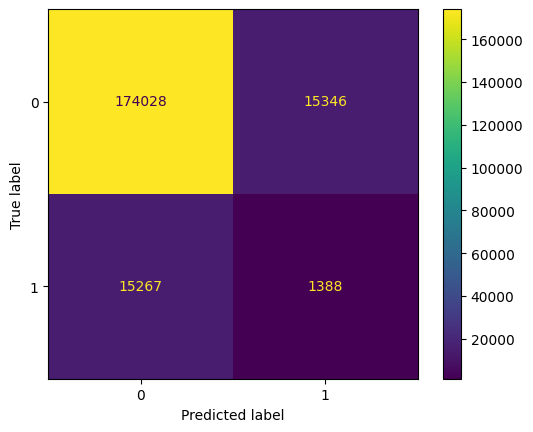

In [10]:
# Créer la matrice de confusion
cm_dummy = confusion_matrix(y_train, y_train_pred)
cm_dummy_display = ConfusionMatrixDisplay(confusion_matrix = cm_dummy, display_labels = [0, 1])
cm_dummy_display.plot()
plt.show()

In [11]:
# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)

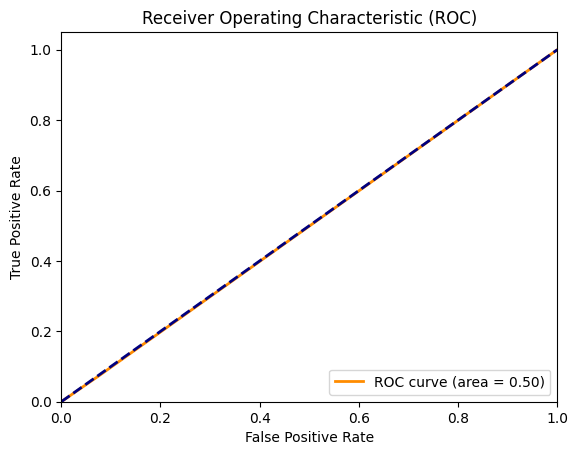

In [12]:
# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_dummy:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### **Métriques sur échantillon Test**

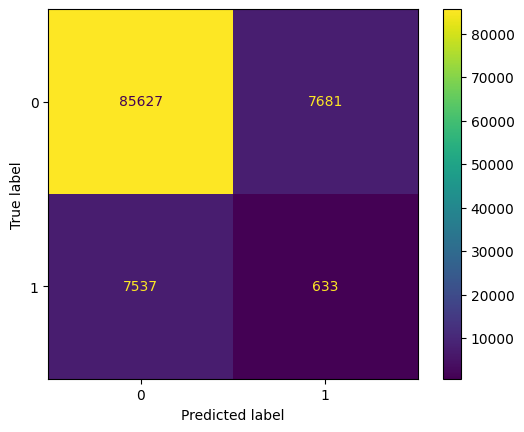

In [13]:
# Créer la matrice de confusion
cm_dummy = confusion_matrix(y_test, y_pred)
cm_dummy_display = ConfusionMatrixDisplay(confusion_matrix = cm_dummy, display_labels = [0, 1])
cm_dummy_display.plot()
plt.show()

In [14]:
# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

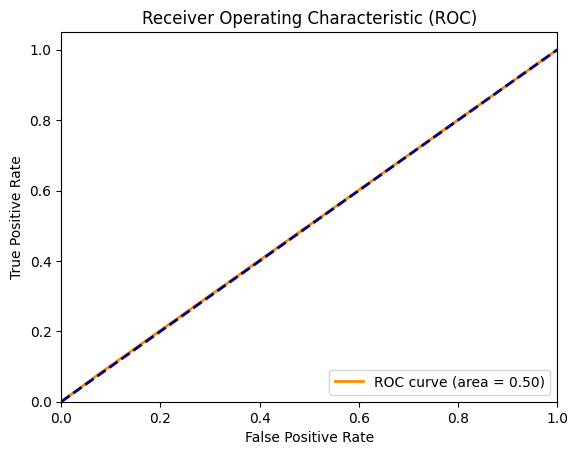

In [15]:
# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_dummy:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## **Régression Logistique**

In [16]:
train_x_logit = X_train.copy()
train_y_logit = y_train.copy()
test_x_logit = X_test.copy()
test_y_logit = y_test.copy()

In [17]:
train_x_logit = train_x_logit.loc[:, ~(train_x_logit.isna().any())]
test_x_logit = test_x_logit.loc[:, ~(test_x_logit.isna().any())]
feats_log_reg = [f for f in train_x_logit.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
test_x_logit = test_x_logit[feats_log_reg]

In [18]:
train_x_logit = np.asarray(train_x_logit,dtype=float)
train_y_logit = np.asarray(train_y_logit,dtype=float)
test_x_logit = np.asarray(test_x_logit,dtype=float)
test_y_logit = np.asarray(test_y_logit,dtype=float)

In [19]:
log_reg = sm.Logit(train_y_logit, train_x_logit).fit()

         Current function value: 0.266696
         Iterations: 35


c:\Users\fly\Documents\Data_Disk_D\Data\fly\Mes documents\FTTH Data\formation_oc\scoring_model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               206029
Model:                          Logit   Df Residuals:                   205856
Method:                           MLE   Df Model:                          172
Date:                Fri, 22 Nov 2024   Pseudo R-squ.:                 0.05027
Time:                        00:19:26   Log-Likelihood:                -54947.
converged:                      False   LL-Null:                       -57855.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3613      0.022    -16.677      0.000      -0.404      -0.319
x2            -0.2946      0.020    -14.944      0.000      -0.333      -0.256
x3            -0.0614      0.019     -3.256      0.0

In [21]:
predictions_log_reg__test = log_reg.predict(test_x_logit)
predictions_log_reg__train = log_reg.predict(train_x_logit)
predicted_classes__test = [1 if x > 0.6 else 0 for x in predictions_log_reg__test] # seuil pour trancher si 1 ou 0
predicted_classes__train = [1 if x > 0.6 else 0 for x in predictions_log_reg__train] # seuil pour trancher si 1 ou 0

### **Métriques sur échantillon Test**

Matrice de confusion

In [22]:
# Création de la matrice de confusion
conf_matrix = confusion_matrix(test_y_logit, predicted_classes__test)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual 0', 'Actual 1'], 
                              columns=['Predicted 0', 'Predicted 1'])
print(conf_matrix_df)

          Predicted 0  Predicted 1
Actual 0        93308            0
Actual 1         8170            0


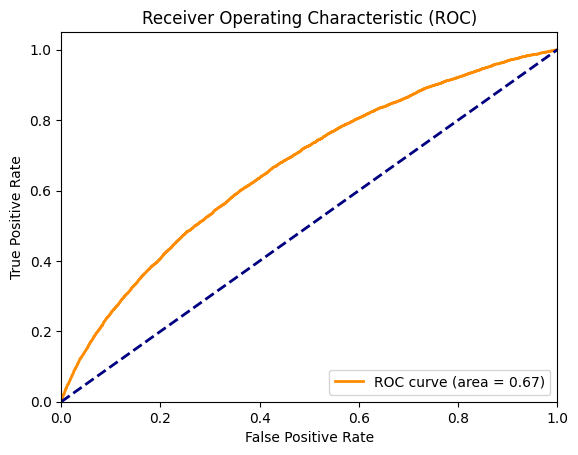

In [23]:
# Calcul des valeurs de la courbe ROC
fpr, tpr, thresholds = roc_curve(test_y_logit, predictions_log_reg__test)
auc = roc_auc_score(test_y_logit, predictions_log_reg__test)

# Plot AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [24]:
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(test_y_logit, predicted_classes__test))

Test accuracy =  0.9194899387059264


### **Métriques sur échantillon Train**

Matrice de Confusion

In [25]:
# Création de la matrice de confusion
conf_matrix = confusion_matrix(train_y_logit, predicted_classes__train)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual 0', 'Actual 1'], 
                              columns=['Predicted 0', 'Predicted 1'])
print(conf_matrix_df)

          Predicted 0  Predicted 1
Actual 0       189372            2
Actual 1        16655            0


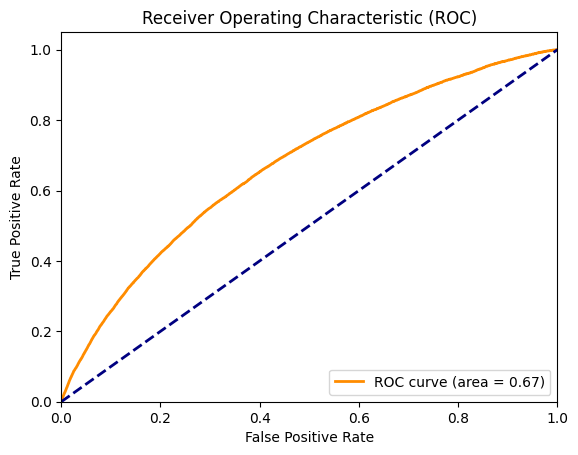

In [26]:
# Calcul des valeurs de la courbe ROC
fpr, tpr, thresholds = roc_curve(train_y_logit, predictions_log_reg__train)
auc = roc_auc_score(train_y_logit, predictions_log_reg__train)

# Plot AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [27]:
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(train_y_logit, predicted_classes__train))

Test accuracy =  0.9191521581913226


# **Arbre de Décision**

In [33]:
# X,Y train, test
x_train__tree = X_train.copy()
y_train__tree = y_train.copy()
x_test__tree = X_test.copy()
y_test__tree = y_test.copy()


x_train__tree = x_train__tree.loc[:, ~(x_train__tree.isna().any())]
x_test__tree = x_test__tree.loc[:, ~(x_test__tree.isna().any())]
feats__tree = [f for f in x_train__tree.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
x_test__tree = x_test__tree[feats__tree]

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(x_train__tree, y_train__tree)
#Predict the response for test dataset
y_pred = clf.predict(y_test__tree)


c:\Users\fly\Documents\Data_Disk_D\Data\fly\Mes documents\FTTH Data\formation_oc\scoring_model\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))